<a href="https://colab.research.google.com/github/Youssef-Keshk/Assignment2-LogisticRegression-SoftmaxRegression-NeuralNets/blob/main/notebooks.partD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


##1. CNN Architecture Definition

In [ ]:
class ConvNet(nn.Module):
    """
    Lightweight CNN for MNIST
    Architecture: Conv -> Pool -> FC
    Compact design with ~25K parameters
    """
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 28x28 -> 28x28x16
        self.pool = nn.MaxPool2d(2, 2)  # Downsample by 2
        self.fc1 = nn.Linear(16 * 14 * 14, 10)  # Direct to output

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.view(-1, 1, 28, 28)
        x = torch.relu(self.conv1(x))  # 28x28x16
        x = self.pool(x)               # 14x14x16
        x = x.view(x.size(0), -1)      # Flatten
        x = self.fc1(x)
        return x


class FullyConnectedNet(nn.Module):
    """
    Traditional fully connected network for comparison
    Architecture: FC -> FC -> FC
    """
    def __init__(self):
        super(FullyConnectedNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Print architecture comparison
cnn = ConvNet()
fcn = FullyConnectedNet()
print(f"\nCNN Parameters: {sum(p.numel() for p in cnn.parameters()):,}")
print(f"FC Parameters:  {sum(p.numel() for p in fcn.parameters()):,}")



CNN Parameters: 31,530
FC Parameters:  109,386


### Prepare Data for CNN

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Create train/validation split
train_idx, val_idx = train_test_split(
    range(len(train_dataset)), test_size=0.2, random_state=42
)

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)

# Data loaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"\nDataset split: Train={len(train_subset)}, Val={len(val_subset)}, Test={len(test_dataset)}")



Dataset split: Train=48000, Val=12000, Test=10000


### Train Simple CNN

In [ ]:
def train_and_evaluate(model, train_loader, val_loader, epochs=15, lr=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_correct = train_total = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            train_total += y.size(0)
            train_correct += (predicted == y).sum().item()

        train_acc = 100 * train_correct / train_total

        # Validation phase
        model.eval()
        val_correct = val_total = 0

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                _, predicted = torch.max(outputs, 1)
                val_total += y.size(0)
                val_correct += (predicted == y).sum().item()

        val_acc = 100 * val_correct / val_total

        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:2d}: Train={train_acc:.2f}%, Val={val_acc:.2f}%")

    return history


def test_accuracy(model, test_loader):
    model.eval()
    correct = total = 0

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    return 100 * correct / total

### Train CNN vs FC

In [ ]:
cnn_model = ConvNet()
cnn_history = train_and_evaluate(cnn_model, train_loader, val_loader, epochs=15)
cnn_test_acc = test_accuracy(cnn_model, test_loader)

print("\n" + "-"*70)
print("Training Fully Connected Network...")
print("-"*70)
fc_model = FullyConnectedNet()
fc_history = train_and_evaluate(fc_model, train_loader, val_loader, epochs=15)
fc_test_acc = test_accuracy(fc_model, test_loader)

Epoch  5: Train=98.53%, Val=97.83%
Epoch 10: Train=99.21%, Val=97.94%
Epoch 15: Train=99.52%, Val=98.15%

----------------------------------------------------------------------
Training Fully Connected Network...
----------------------------------------------------------------------
Epoch  5: Train=98.33%, Val=97.38%
Epoch 10: Train=99.17%, Val=97.46%
Epoch 15: Train=99.49%, Val=97.59%


### Compare CNN vs Fully Connected

In [ ]:

print(f"\nFinal Performance:")
print(f"  CNN:  Val={cnn_history['val_acc'][-1]:.2f}%, Test={cnn_test_acc:.2f}%")
print(f"  FC:   Val={fc_history['val_acc'][-1]:.2f}%, Test={fc_test_acc:.2f}%")
print(f"  Improvement: +{cnn_test_acc - fc_test_acc:.2f}%")

print(f"\nParameter Efficiency:")
cnn_params = sum(p.numel() for p in cnn_model.parameters())
fc_params = sum(p.numel() for p in fc_model.parameters())
print(f"  CNN: {cnn_params:,} parameters → {cnn_test_acc:.2f}% accuracy")
print(f"  FC:  {fc_params:,} parameters → {fc_test_acc:.2f}% accuracy")
print(f"  CNN achieves better accuracy with {(1 - cnn_params/fc_params)*100:.1f}% fewer parameters!")

print("\n Key Insights:")
print("   CNNs exploit spatial locality in images")
print("   Weight sharing reduces parameters while improving generalization")
print("   Translation invariance: features detected anywhere in image")
print("   Hierarchical learning: edges → shapes → digits")


Final Performance:
  CNN:  Val=98.15%, Test=97.94%
  FC:   Val=97.59%, Test=97.46%
  Improvement: +0.48%

Parameter Efficiency:
  CNN: 31,530 parameters → 97.94% accuracy
  FC:  109,386 parameters → 97.46% accuracy
  CNN achieves better accuracy with 71.2% fewer parameters!

 Key Insights:
   CNNs exploit spatial locality in images
   Weight sharing reduces parameters while improving generalization
   Translation invariance: features detected anywhere in image
   Hierarchical learning: edges → shapes → digits


## Visualize CNN vs FC

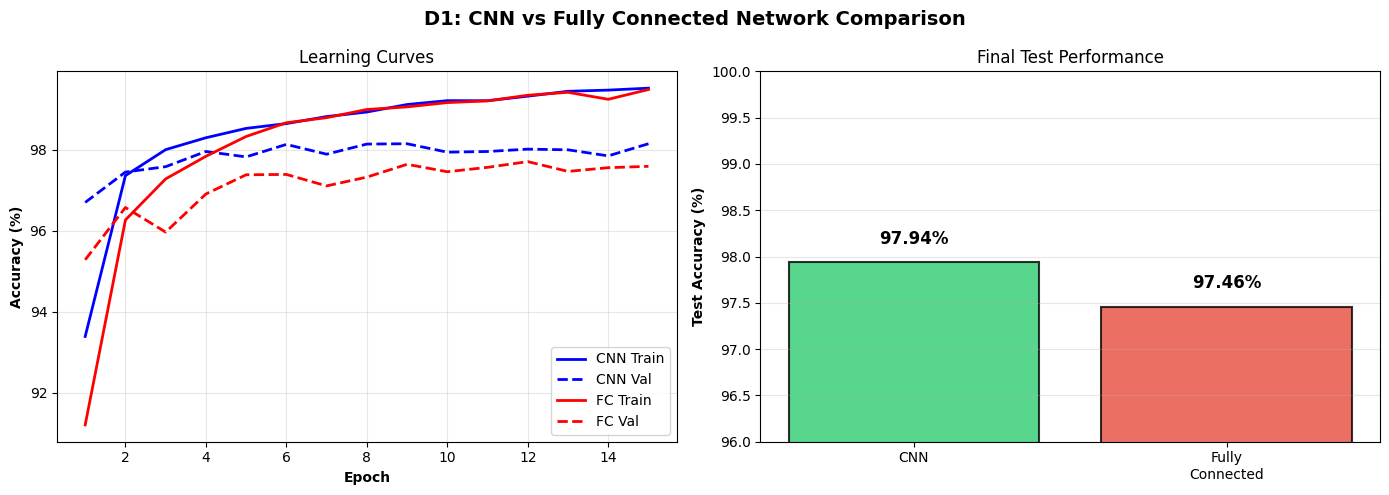

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('D1: CNN vs Fully Connected Network Comparison',
             fontsize=14, fontweight='bold')

# Learning curves
ax = axes[0]
epochs_range = range(1, 16)
ax.plot(epochs_range, cnn_history['train_acc'], 'b-', label='CNN Train', linewidth=2)
ax.plot(epochs_range, cnn_history['val_acc'], 'b--', label='CNN Val', linewidth=2)
ax.plot(epochs_range, fc_history['train_acc'], 'r-', label='FC Train', linewidth=2)
ax.plot(epochs_range, fc_history['val_acc'], 'r--', label='FC Val', linewidth=2)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontweight='bold')
ax.set_title('Learning Curves')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
# Test accuracy comparison
ax = axes[1]
models = ['CNN', 'Fully\nConnected']
test_accs = [cnn_test_acc, fc_test_acc]
colors = ['#2ecc71', '#e74c3c']
bars = ax.bar(models, test_accs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Test Accuracy (%)', fontweight='bold')
ax.set_title('Final Test Performance')
ax.set_ylim([96, 100])
ax.grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars, test_accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{acc:.2f}%', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('d1_cnn_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. REGULARIZATION TECHNIQUES


### Regularized Network


In [ ]:
class RegularizedNet(nn.Module):
    """
    Flexible neural network with configurable regularization
    - Dropout: Randomly drops neurons during training to prevent co-adaptation
    - Batch Normalization: Normalizes layer inputs for stable training
    """
    def __init__(self, dropout_rate=0.0, use_batch_norm=False):
        super(RegularizedNet, self).__init__()

        self.use_batch_norm = use_batch_norm

        # Network layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        # Batch normalization (optional)
        if use_batch_norm:
            self.bn1 = nn.BatchNorm1d(256)
            self.bn2 = nn.BatchNorm1d(128)

        # Dropout (optional)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None

    def forward(self, x):
        x = x.view(x.size(0), -1)

        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x) if self.use_batch_norm else x
        x = torch.relu(x)
        x = self.dropout(x) if self.dropout else x

        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x) if self.use_batch_norm else x
        x = torch.relu(x)
        x = self.dropout(x) if self.dropout else x

        # Output layer
        x = self.fc3(x)
        return x


### Dropout Analysis

In [ ]:
print("\n" + "-"*70)
print("DROPOUT ANALYSIS: Effect on Overfitting")
print("-"*70)

dropout_rates = [0.0, 0.1, 0.3, 0.5, 0.7]
dropout_results = {}

for rate in dropout_rates:
    print(f"\n→ Training with Dropout Rate: {rate}")

    model = RegularizedNet(dropout_rate=rate, use_batch_norm=False)
    history = train_and_evaluate(model, train_loader, val_loader, epochs=15)
    test_acc = test_accuracy(model, test_loader)

    # Calculate overfitting (gap between train and val accuracy)
    final_train = history['train_acc'][-1]
    final_val = history['val_acc'][-1]
    overfitting_gap = final_train - final_val

    dropout_results[rate] = {
        'history': history,
        'test_acc': test_acc,
        'overfitting': overfitting_gap,
        'train_acc': final_train,
        'val_acc': final_val
    }

    print(f"  Train={final_train:.2f}%, Val={final_val:.2f}%, Test={test_acc:.2f}%")
    print(f"  Overfitting Gap: {overfitting_gap:.2f}%")


----------------------------------------------------------------------
DROPOUT ANALYSIS: Effect on Overfitting
----------------------------------------------------------------------

→ Training with Dropout Rate: 0.0
Epoch  5: Train=98.58%, Val=97.52%
Epoch 10: Train=99.31%, Val=97.34%
Epoch 15: Train=99.62%, Val=97.88%
  Train=99.62%, Val=97.88%, Test=97.64%
  Overfitting Gap: 1.74%

→ Training with Dropout Rate: 0.1
Epoch  5: Train=98.24%, Val=97.38%
Epoch 10: Train=98.81%, Val=97.89%
Epoch 15: Train=99.22%, Val=97.87%
  Train=99.22%, Val=97.87%, Test=97.92%
  Overfitting Gap: 1.36%

→ Training with Dropout Rate: 0.3
Epoch  5: Train=97.03%, Val=97.46%
Epoch 10: Train=97.87%, Val=97.67%
Epoch 15: Train=98.26%, Val=97.96%
  Train=98.26%, Val=97.96%, Test=98.07%
  Overfitting Gap: 0.30%

→ Training with Dropout Rate: 0.5
Epoch  5: Train=94.93%, Val=96.98%
Epoch 10: Train=96.09%, Val=97.36%
Epoch 15: Train=96.54%, Val=97.71%
  Train=96.54%, Val=97.71%, Test=97.76%
  Overfitting Gap: -1.

### Batch Norm Analysis

In [ ]:
configs = [
    ("Baseline (No Regularization)", 0.0, False),
    ("Dropout Only (0.5)", 0.5, False),
    ("BatchNorm Only", 0.0, True),
    ("Dropout + BatchNorm", 0.5, True)
]

reg_results = {}

for name, dropout, batch_norm in configs:
    print(f"\n→ Training: {name}")

    model = RegularizedNet(dropout_rate=dropout, use_batch_norm=batch_norm)
    history = train_and_evaluate(model, train_loader, val_loader, epochs=15)
    test_acc = test_accuracy(model, test_loader)

    reg_results[name] = {
        'history': history,
        'test_acc': test_acc,
        'train_acc': history['train_acc'][-1],
        'val_acc': history['val_acc'][-1]
    }

    print(f"  Test Accuracy: {test_acc:.2f}%")



→ Training: Baseline (No Regularization)
Epoch  5: Train=98.60%, Val=97.45%
Epoch 10: Train=99.31%, Val=97.34%
Epoch 15: Train=99.55%, Val=97.84%
  Test Accuracy: 97.81%

→ Training: Dropout Only (0.5)
Epoch  5: Train=94.96%, Val=96.75%
Epoch 10: Train=96.02%, Val=97.37%
Epoch 15: Train=96.58%, Val=97.67%
  Test Accuracy: 97.66%

→ Training: BatchNorm Only
Epoch  5: Train=98.79%, Val=97.75%
Epoch 10: Train=99.37%, Val=98.14%
Epoch 15: Train=99.59%, Val=97.97%
  Test Accuracy: 97.86%

→ Training: Dropout + BatchNorm
Epoch  5: Train=94.78%, Val=97.20%
Epoch 10: Train=96.17%, Val=97.84%
Epoch 15: Train=96.88%, Val=97.78%
  Test Accuracy: 97.93%


### Visualize Regularization

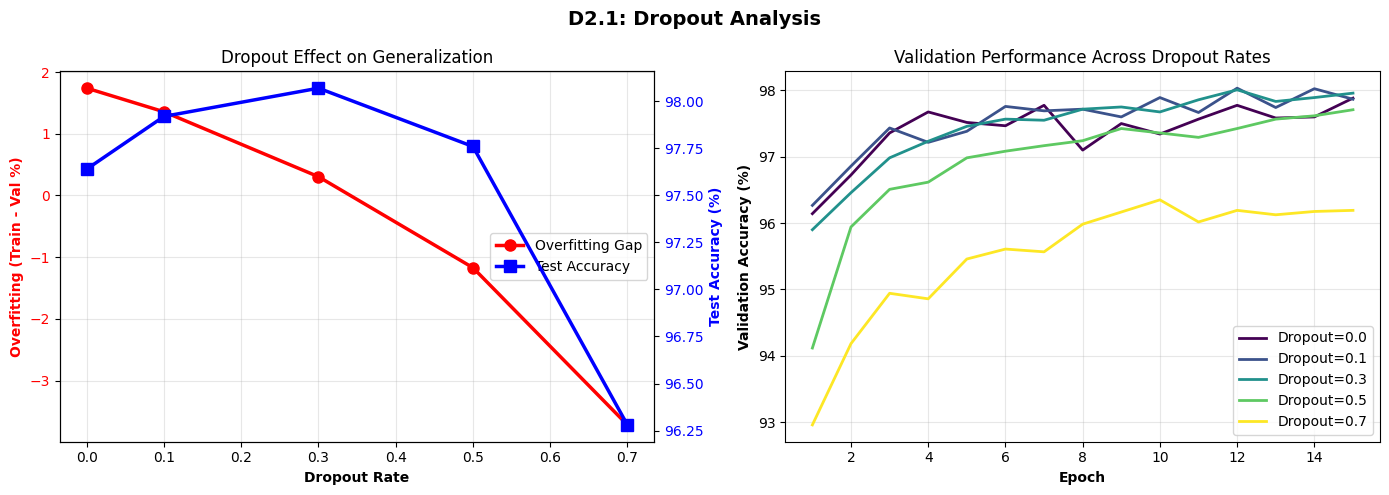

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('D2.1: Dropout Analysis', fontsize=14, fontweight='bold')

# Dropout effect on overfitting and accuracy
ax = axes[0]
rates = list(dropout_results.keys())
overfit_gaps = [dropout_results[r]['overfitting'] for r in rates]
test_accs = [dropout_results[r]['test_acc'] for r in rates]

ax2 = ax.twinx()
line1 = ax.plot(rates, overfit_gaps, 'ro-', label='Overfitting Gap',
                linewidth=2.5, markersize=8)
line2 = ax2.plot(rates, test_accs, 'bs-', label='Test Accuracy',
                 linewidth=2.5, markersize=8)

ax.set_xlabel('Dropout Rate', fontweight='bold')
ax.set_ylabel('Overfitting (Train - Val %)', color='r', fontweight='bold')
ax2.set_ylabel('Test Accuracy (%)', color='b', fontweight='bold')
ax.set_title('Dropout Effect on Generalization')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='y', labelcolor='r')
ax2.tick_params(axis='y', labelcolor='b')

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='center right')

# Learning curves for different dropout rates
ax = axes[1]
colors = plt.cm.viridis(np.linspace(0, 1, len(dropout_rates)))
for rate, color in zip(dropout_rates, colors):
    history = dropout_results[rate]['history']
    ax.plot(range(1, 16), history['val_acc'],
            label=f'Dropout={rate}', color=color, linewidth=2)

ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Validation Accuracy (%)', fontweight='bold')
ax.set_title('Validation Performance Across Dropout Rates')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('d2_dropout_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Regularization Comparison Visualization

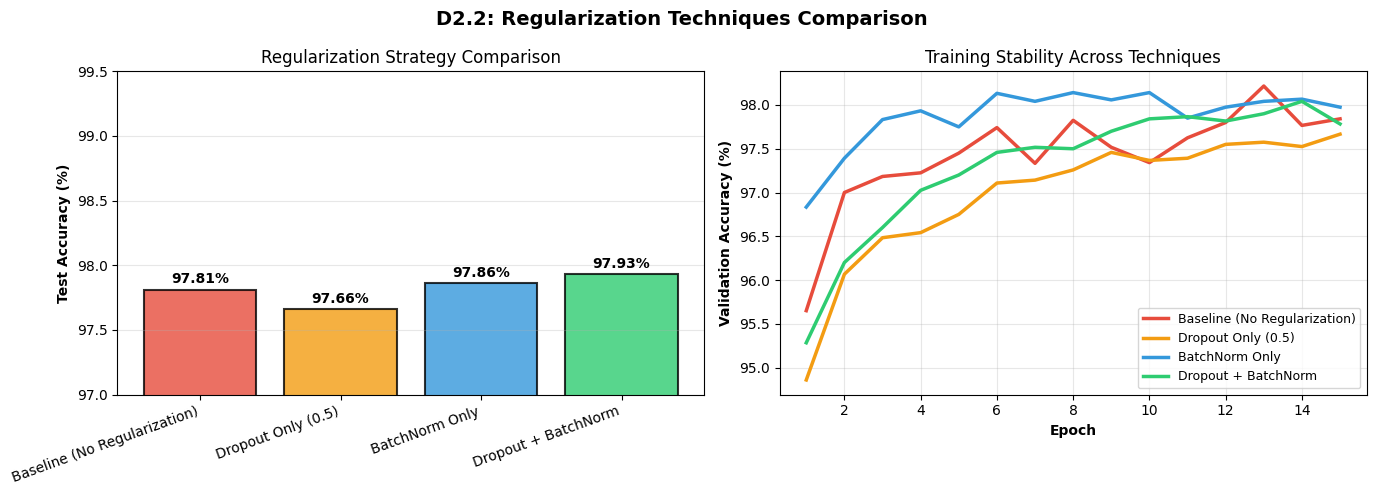

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('D2.2: Regularization Techniques Comparison',
             fontsize=14, fontweight='bold')

# Bar chart comparison
ax = axes[0]
names = list(reg_results.keys())
test_scores = [reg_results[n]['test_acc'] for n in names]
colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']

bars = ax.bar(range(len(names)), test_scores, color=colors, alpha=0.8,
              edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=20, ha='right')
ax.set_ylabel('Test Accuracy (%)', fontweight='bold')
ax.set_title('Regularization Strategy Comparison')
ax.set_ylim([97, 99.5])
ax.grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars, test_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{acc:.2f}%', ha='center', fontsize=10, fontweight='bold')

# Learning stability comparison
ax = axes[1]
for name, color in zip(names, colors):
    history = reg_results[name]['history']
    ax.plot(range(1, 16), history['val_acc'],
            label=name, color=color, linewidth=2.5)

ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Validation Accuracy (%)', fontweight='bold')
ax.set_title('Training Stability Across Techniques')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('d2_regularization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary

In [ ]:
print("\n D1: CONVOLUTIONAL NEURAL NETWORKS")
print("-" * 70)
print(f"Performance Comparison:")
print(f"  • CNN Test Accuracy:      {cnn_test_acc:.2f}%")
print(f"  • FC Test Accuracy:       {fc_test_acc:.2f}%")
print(f"  • Performance Gain:       +{cnn_test_acc - fc_test_acc:.2f}%")
print(f"\nParameter Efficiency:")
print(f"  • CNN Parameters:         {cnn_params:,}")
print(f"  • FC Parameters:          {fc_params:,}")
print(f"  • Reduction:              {(1 - cnn_params/fc_params)*100:.1f}%")
print(f"\nKey Advantages of CNNs:")
print(f"  ✓ Exploit spatial locality through local receptive fields")
print(f"  ✓ Weight sharing reduces parameters and improves generalization")
print(f"  ✓ Translation invariance for robust feature detection")
print(f"  ✓ Hierarchical feature learning (edges → shapes → objects)")

print("\n D2: REGULARIZATION TECHNIQUES")
print("-" * 70)

best_dropout = max(dropout_results, key=lambda k: dropout_results[k]['test_acc'])
print(f"Dropout Analysis:")
print(f"  • Best dropout rate:      {best_dropout}")
print(f"  • Test accuracy:          {dropout_results[best_dropout]['test_acc']:.2f}%")
print(f"  • Overfitting reduction:  {dropout_results[0.0]['overfitting'] - dropout_results[best_dropout]['overfitting']:.2f}%")

best_config = max(reg_results, key=lambda k: reg_results[k]['test_acc'])
print(f"\nBest Configuration:")
print(f"  • Strategy:               {best_config}")
print(f"  • Test accuracy:          {reg_results[best_config]['test_acc']:.2f}%")
print(f"  • Train accuracy:         {reg_results[best_config]['train_acc']:.2f}%")
print(f"  • Validation accuracy:    {reg_results[best_config]['val_acc']:.2f}%")

print(f"\nRegularization Insights:")
print(f"  ✓ Dropout prevents neuron co-adaptation → better generalization")
print(f"  ✓ BatchNorm stabilizes training → faster convergence")
print(f"  ✓ Combined approach yields best performance")
print(f"  ✓ Moderate dropout (0.3-0.5) balances regularization vs capacity")



 D1: CONVOLUTIONAL NEURAL NETWORKS
----------------------------------------------------------------------
Performance Comparison:
  • CNN Test Accuracy:      97.94%
  • FC Test Accuracy:       97.46%
  • Performance Gain:       +0.48%

Parameter Efficiency:
  • CNN Parameters:         31,530
  • FC Parameters:          109,386
  • Reduction:              71.2%

Key Advantages of CNNs:
  ✓ Exploit spatial locality through local receptive fields
  ✓ Weight sharing reduces parameters and improves generalization
  ✓ Translation invariance for robust feature detection
  ✓ Hierarchical feature learning (edges → shapes → objects)

 D2: REGULARIZATION TECHNIQUES
----------------------------------------------------------------------
Dropout Analysis:
  • Best dropout rate:      0.3
  • Test accuracy:          98.07%
  • Overfitting reduction:  1.44%

Best Configuration:
  • Strategy:               Dropout + BatchNorm
  • Test accuracy:          97.93%
  • Train accuracy:         96.88%
  • Val